In [17]:
import os
from PIL import Image

# Model 관련
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
# 데이터 관련
import torch
from torch.utils.data import Dataset
import utils
from pycocotools.coco import COCO

In [2]:
def get_model(num_classes=2):
    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    
    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [3]:
num_classes = 2  # 1 class (person) + background

In [4]:
class CocoDataset(Dataset):
    def __init__(self, root, json, transform=None):
        """
        Args:
            root: image directory.
            json: coco annotation file path.
            transform: image, target transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        
        ann_id = self.ids[index]
        img_id = self.coco.anns[ann_id]['image_id']
        
        path = self.coco.loadImgs(img_id)[0]['file_name']
        image = Image.open(os.path.join(self.root, path)).convert('RGB')

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        # list로 나옴 [{'iscrowd': 0, ...}, {'iscrowd': 0, ...}, ...]
        # 이미지 하나에 여러 개의 annotation이 있을 수 있다. 
        coco_annotation = self.coco.loadAnns(ann_ids)
        
        # annotation 갯수 = 이미지내의 object 갯수
        num_objs = len(coco_annotation)
        
        # annotation들을 모두 torch.tensor로 만든다.
        # BBox 처리
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # background = 0, smartphone = 1
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        img_id = torch.tensor([img_id])
        
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        target["area"] = areas
        target["iscrowd"] = iscrowd
        
        if self.transform is not None:
            image, target = self.transform(image, target)
        
        return image, target

    def __len__(self):
        return len(self.ids)

In [5]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# data loader test
img_path = '/home/aiteam/tykim/scratch/lightweight/my_detection/hold_smartphone/imgs'
train_json = '/home/aiteam/tykim/scratch/lightweight/my_detection/hold_smartphone/annos/train.json'
dataset = CocoDataset(root=img_path, json= train_json, transform=get_transform(True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)

In [47]:
# Model forward check
model = get_model(2)

In [48]:
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

In [52]:
output = model(images,targets)

In [55]:
output['loss_classifier']

tensor(0.6461, grad_fn=<NllLossBackward0>)

In [6]:
# Train
img_path = '/home/aiteam/tykim/scratch/lightweight/my_detection/hold_smartphone/imgs'
train_json = '/home/aiteam/tykim/scratch/lightweight/my_detection/hold_smartphone/annos/train.json'
test_json = '/home/aiteam/tykim/scratch/lightweight/my_detection/hold_smartphone/annos/val.json'
dataset = CocoDataset(root=img_path, json= train_json, transform=get_transform(True))
dataset_test = CocoDataset(root=img_path, json= train_json, transform=get_transform(False))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
num_epochs = 10
model = get_model(num_classes)
model.to(device)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
                
                
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [8]:
from torch.optim.lr_scheduler import StepLR
from engine import train_one_epoch, evaluate
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/64]  eta: 0:03:19  lr: 0.000084  loss: 0.7850 (0.7850)  loss_classifier: 0.6620 (0.6620)  loss_box_reg: 0.1020 (0.1020)  loss_objectness: 0.0198 (0.0198)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 3.1246  data: 0.3667  max mem: 2566
Epoch: [0]  [10/64]  eta: 0:00:22  lr: 0.000877  loss: 0.5468 (0.5632)  loss_classifier: 0.3761 (0.3870)  loss_box_reg: 0.1705 (0.1681)  loss_objectness: 0.0026 (0.0048)  loss_rpn_box_reg: 0.0024 (0.0033)  time: 0.4231  data: 0.0376  max mem: 2853
Epoch: [0]  [20/64]  eta: 0:00:12  lr: 0.001670  loss: 0.4253 (0.4652)  loss_classifier: 0.2257 (0.2916)  loss_box_reg: 0.1589 (0.1639)  loss_objectness: 0.0041 (0.0065)  loss_rpn_box_reg: 0.0028 (0.0032)  time: 0.1523  data: 0.0055  max mem: 2853
Epoch: [0]  [30/64]  eta: 0:00:08  lr: 0.002463  loss: 0.2730 (0.3875)  loss_classifier: 0.0967 (0.2217)  loss_box_reg: 0.1399 (0.1553)  loss_objectness: 0.0064 (0.0074)  loss_rpn_box_reg: 0.0025 (0.0031)  time: 0.1529  data: 0.0066  max mem: 2853
Epoch: [

In [11]:
import inspect
inspect.getmro(torchvision.models.detection.faster_rcnn.FasterRCNN)

(torchvision.models.detection.faster_rcnn.FasterRCNN,
 torchvision.models.detection.generalized_rcnn.GeneralizedRCNN,
 torch.nn.modules.module.Module,
 object)

In [15]:
# For inference
# test dataset에서 이미지 하나를 가져옴
img, _ = dataset_test[0]
# 모델을 eval mode로
model.eval()
with torch.no_grad(): 
    predictions = model([img.to(device)])

In [16]:
predictions

[{'boxes': tensor([[339.7930, 211.3397, 384.1283, 257.6976]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9901], device='cuda:0')}]

In [39]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.io.image import read_image

img = read_image("/home/aiteam/tykim/scratch/lightweight/my_detection/hold_smartphone/imgs/a116.jpg", torchvision.io.image.ImageReadMode.RGB)

In [48]:
weight = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
preprocess = weight.transforms()
batch = [preprocess(img).to('cuda')]

In [49]:
prediction = model(batch)[0]

In [51]:
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=['smartphone'],
                          colors="red",
                          width=4, font_size=30)

/home/aiteam/miniconda3/envs/loader/lib/python3.9/site-packages/torchvision/utils.py:237: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


In [52]:
im = to_pil_image(box.detach()) # PIL.Image.Image 리턴됨

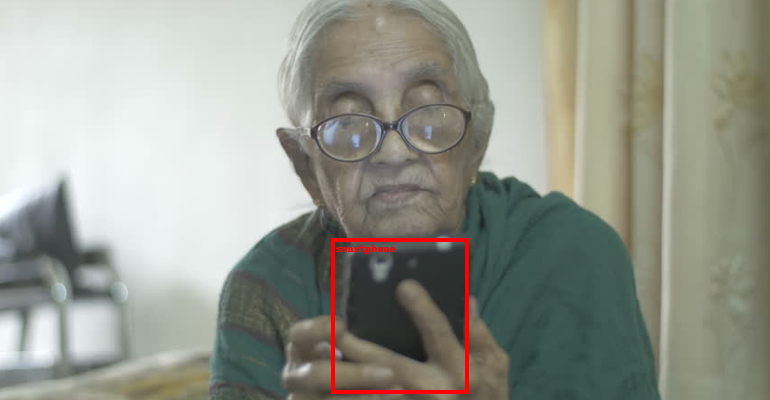

In [55]:
im

In [ ]:
torch.save(model, '/home/aiteam/tykim/scratch/lightweight/my_detection/faster_rcnn_v1.pth')

In [ ]:
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
torch.onnx.export(model, x, "faster_rcnn.onnx", opset_version = 11)